In [1]:
#install.packages(c('tidyverse', 'tidytext", 'dplyr', 'ggplot2', 'wordcloud','rjson', 'quanteda', 'feather', 'cld2', 'ggplot2', 'plotly', 'scales', 'cowplot', 'tau', 'stopwords', 'tm', 'textstem', 'pbapply', 'text2vec', 'rlist', 'dbscan'))

library(rjson); library(tidyverse); library(quanteda); library(feather); library(cld2); library(ggplot2); library(plotly); library(scales); library(cowplot); library(tau); library(stopwords); library(tm); library(textstem); library(pbapply); library(text2vec); library(rlist); library(wordcloud); library(dbscan)

Warning message:
"package 'tidyverse' was built under R version 3.6.3"
-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.3     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

Warning message:
"package 'ggplot2' was built under R version 3.6.3"
Warning message:
"package 'tibble' was built under R version 3.6.3"
Warning message:
"package 'tidyr' was built under R version 3.6.3"
Warning message:
"package 'purrr' was built under R version 3.6.3"
Warning message:
"package 'dplyr' was built under R version 3.6.3"
Warning message:
"package 'forcats' was built under R version 3.6.3"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Warning message:
"package 'quanteda' was built under R version 3.6.3"
Package version: 2.1.2

Parallel computing: 2 of 16 threads used.


CODIGO PARA CARGAR METADATA Y VER SU ESTRUCTURA

In [2]:
# Cargamos los datos del archivo "metadata.csv"
# stringAsFactors evita que las cadenas de texto se conviertan en factores
# na.strings indica qué consideramos valores nulos. En este caso celdas vacías y "NA"
metadata_df <- read.csv("D:/COVID/metadata.csv", stringsAsFactors = FALSE, na.strings = c("", "NA"))

# str() permite ver la estructura del archivo: número de filas, columnas y muestra el primero objeto almacenado
str(metadata_df)


'data.frame':	253454 obs. of  19 variables:
 $ cord_uid        : chr  "ug7v899j" "02tnwd4m" "ejv2xln0" "2b73a28n" ...
 $ sha             : chr  "d1aafb70c066a2068b02786f8929fd9c900897fb" "6b0567729c2143a66d737eb0a2f63f2dce2e5a7d" "06ced00a5fc04215949aa72528f2eeaae1d58927" "348055649b6b8cf2b9a376498df9bf41f7123605" ...
 $ source_x        : chr  "PMC" "PMC" "PMC" "PMC" ...
 $ title           : chr  "Clinical features of culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jed"| __truncated__ "Nitric oxide: a pro-inflammatory mediator in lung disease?" "Surfactant protein-D and pulmonary host defense" "Role of endothelin-1 in lung disease" ...
 $ doi             : chr  "10.1186/1471-2334-1-6" "10.1186/rr14" "10.1186/rr19" "10.1186/rr44" ...
 $ pmcid           : chr  "PMC35282" "PMC59543" "PMC59549" "PMC59574" ...
 $ pubmed_id       : chr  "11472636" "11667967" "11667972" "11686871" ...
 $ license         : chr  "no-cc" "no-cc" "no-cc" "no-cc" ...
 $ abstr

FUNCIÓN PARA EXTRAER INFORMACIÓN

In [6]:
# Función de ayuda  para extraer información de JSON
leer_json <- function(json){
  # Obtenemos el identificador del texto
  paper_id <- json$paper_id
  # Obtenemos sus autores
  authors <- json$metadata$authors
  author_list <- list()
  # Separamos cada autor
  for (author in authors) {
      name <- paste0(author$first," ", author$last, ";")
      author_list <- paste0(author_list, as.character(name))
  }
  # Obtenemos el título del artículo
  title_text <- json$metadata$title
  # Obtenemos todo el abstract o resumen
  abstract_text <- ''
  for (each_abstract in json$abstract) {
      abstract_text <- paste(abstract_text, each_abstract$text)
  }
  # Obtenemos el cuerpo del artículo
  body_text <- ''
  for (each_body in json$body_text) {
      body_text <- paste(body_text, each_body$text)
  }

  # Devolvemos el resultado en forma de Data Frame
  return(tibble(paper_id, author_list, title_text, abstract_text, body_text))
}

DIRECTORIO DE LOS ARCHIVOS

In [4]:
# Identificamos la carpeta que contiene los JSON
directorio <- 'D:/COVID/document_parses/pdf_json/'
#Cogemos todos los archivos del directorio
archivos <- list.files(directorio)
# Mostramos el número de archivos
length(archivos)

[1] 106137

PROCESAMIENTO DE LOS ARHIVOS (covid_df.csv)

30 minutos

In [7]:
# Inicializamos el contenido del artíuculo en formato lista
articulos <- list()
# Inicializamos el índice de artículos
indice <- 0

# Iteramos cada uno de los archivos
for (archivo in archivos) {
  # Actualizamos el puntero
  indice <- indice + 1
  # Breve comprobación para mostrar el estado de carga
  if (indice %% (length(archivos) %/% 10) == 0) {
    cat("Artículos procesados:  ", indice, " de ", length(archivos), "\n")
  }
  
  # Modificamos el camino o PATH hacia el archivo actual
  ruta_archivo <- paste0(directorio, '/', archivo)
  # Convertimos el archivo JSON a objeto de R para poder tratarlo
  json <- fromJSON(file = ruta_archivo)
  # Aplicamos la función para extraer la informaciópn del archivo
  contenido <- leer_json(json)
  
  # Comprobamos si el formato del archivo es el correcto
  if(length(contenido$paper_id) > 0){
    # Si se ha obtenido información del archivo
    # Buscamos el artículo en el archivo "metadata.csv"
    meta <- metadata_df[which(metadata_df$sha == contenido$paper_id), ] 
    # Si no hay información en metadata.csv o el cuerpo del artículo está vacío saltamos el artículo
    if (length(meta) > 0 | length(contenido$body_text) <= 0) {
      # Si no se encuentra autor en el JSON buscamos en metadata      
      if (length(contenido$author_list) <= 0) {
        authors <- metadata_df$authors
        author_list <- list()
        # Separamos cada autor
        for (author in authors) {
            name <- paste0(author$first," ", author$last, ";")
            author_list <- paste0(author_list, as.character(name))
        }
        # Sustituimos los autores
        contenido$author_list <- author_list
      }
      
      # Si no se encuentra el título en el JSON lo buscamos en metadata
      if (contenido$title_text == '') {
        contenido$title_text <- 'NoIncluido'
      }
      
      # Si no se encuentra el abstract lo dejamos como 'No incluido'
      if (nchar(contenido$abstract_text) <= 0) {
        contenido$abstract_text <- 'NoIncluido'
      }

      # Añadimos la revista de publicación
      if (length(meta$journal) > 0) {
        contenido$journal <- meta$journal[1]
      }
      else {
        contenido$journal <- 'NoIncluido'
      }
      # Añadimos el DOI
      if (length(meta$doi) > 0) {
        contenido$doi <- meta$doi[1]
      }
      else {
        contenido$doi <- 'NoIncluido'
      }
   
      # Incluimos el contenido al conjunto de artículos
      articulos[[indice]] <- contenido
    }
  }
}

# Enlazamos todas las filas generadas en un único Data Frame
covid_df <- bind_rows(articulos)

Artículos procesados:   10613  de  106137 
Artículos procesados:   21226  de  106137 
Artículos procesados:   31839  de  106137 
Artículos procesados:   42452  de  106137 
Artículos procesados:   53065  de  106137 
Artículos procesados:   63678  de  106137 
Artículos procesados:   74291  de  106137 
Artículos procesados:   84904  de  106137 
Artículos procesados:   95517  de  106137 
Artículos procesados:   106130  de  106137 


In [10]:
# Observamos la primera fila del nuevo Data Frame menos el cuerpo
as.list(covid_df[1, -5])
# Comprobamos el número de artículos existentes
nrow(covid_df)

$paper_id
[1] "0001418189999fea7f7cbe3e82703d71c85a6fe5"

$author_list
[1] "E Cornelissen;H Dewerchin;E Hamme;H Nauwynck;"

$title_text
[1] "Absence of surface expression of feline infectious peritonitis virus (FIPV) antigens on infected cells isolated from cats with FIP"

$abstract_text
[1] " Feline infectious peritonitis virus (FIPV) positive cells are present in pyogranulomas and exudates from cats with FIP. These cells belong mainly to the monocyte/macrophage lineage. How these cells survive in immune cats is not known. In this study, FIPV positive cells were isolated from pyogranulomas and exudates of 12 naturally FIPV-infected cats and the presence of two immunologic targets, viral antigens and MHC I, on their surface was determined. The majority of the infected cells were confirmed to be cells from the monocyte/macrophage lineage. No surface expression of viral antigens was detected on FIPV positive cells. MHC I molecules were present on all the FIPV positive cells. After cultivation of the isolated infected cells, 52 AE 10% of the infected cells re-expressed viral antigens on the plasma membrane. In conclusion, it can be stated that in FIP cats, FIPV replicates in cells of the monocyte/macrophage lineage without carrying viral antigens in their plasma membrane, which could allow them to escape from antibody-dependent cell lysis. #"

$all_text
[1] "Absence of surface expression of feline infectious peritonitis virus (FIPV) antigens on infected cells isolated from cats with FIP  Feline infectious peritonitis virus (FIPV) positive cells are present in pyogranulomas and exudates from cats with FIP. These cells belong mainly to the monocyte/macrophage lineage. How these cells survive in immune cats is not known. In this study, FIPV positive cells were isolated from pyogranulomas and exudates of 12 naturally FIPV-infected cats and the presence of two immunologic targets, viral antigens and MHC I, on their surface was determined. The majority of the infected cells were confirmed to be cells from the monocyte/macrophage lineage. No surface expression of viral antigens was detected on FIPV positive cells. MHC I molecules were present on all the FIPV positive cells. After cultivation of the isolated infected cells, 52 AE 10% of the infected cells re-expressed viral antigens on the plasma membrane. In conclusion, it can be stated that in FIP cats, FIPV replicates in cells of the monocyte/macrophage lineage without carrying viral antigens in their plasma membrane, which could allow them to escape from antibody-dependent cell lysis. #  Feline infectious peritonitis (FIP) is a fatal chronic disease in cats caused by a coronavirus, feline infectious peritonitis virus (FIPV), and characterized by granulomatous lesions formed at the serosae of different organs. Two forms can be distinguished. Cats suffering from the wet or effusive form have exudates in their body cavities. Exudate is absent in the second form, hence the name dry or non-effusive form. FIPV-infected cells are detected in the pyogranulomas and, based on morphology and the granulocyte/ monocyte/macrophage marker calprotectin, defined as macrophages (Weiss and Scott, 1981; Kipar et al., 1998) . Infected mononuclear cells were also isolated from exudates (Cammarata Parodi et al., 1993; Paltrinieri et al., 1999) . In one way or another, these infected cells succeed in staying alive and transmitting www.elsevier.com/locate/vetmic Veterinary Microbiology 121 (2007) [131] [132] [133] [134] [135] [136] [137] virus to new susceptible cells in the presence of a high concentration of antibodies. How they do this, is not known. Infected cells are normally eliminated by the adaptive immune system through antibody-mediated lysis or cell-mediated lysis. For the antibody-mediated lysis, the presence of antigens on the surface of infected cells is important for the recognition of these cells by antibodies and the subsequent destruction by the immune system (Sissons and Oldstone, 1980) . 

[1] 95980

¡¡¡¡CONTADOR DE PALABRAS!!!! (/covid_df_feather_palabras)
1 minutos

In [13]:
# Contamos el número de palabras para el abstracto ...
covid_df$words_abstract <- apply(covid_df['abstract_text'], 2, function(s) str_count(s, '\\w+'))
# ... y el cuerpo del texto
covid_df$words_body <- apply(covid_df['body_text'], 2, function(s) str_count(s, '\\w+'))
# Mostramos el número de palabras de los primeros textos


In [19]:
head(covid_df[,c('title_text', 'words_abstract', 'words_body')])

title_text,words_abstract,words_body
<chr>,"<int[,1]>","<int[,1]>"
Absence of surface expression of feline infectious peritonitis virus (FIPV) antigens on infected cells isolated from cats with FIP,170,2120
Detection of Severe Acute Respiratory Syndrome Coronavirus 2 (SARS-CoV-2) by Mass Spectrometry,267,2024
Title: Rethinking high-risk groups in COVID-19,1,977
ScienceDirect ScienceDirect Effect of Nanomaterial Shape on Fabrication of Conformal Circuits,344,3331
Plasma inflammatory cytokines and chemokines in severe acute respiratory syndrome,203,2968
"Journal Pre-proofs The Fire This Time: The Stress of Racism, Inflammation and COVID-19",1,1020


¡¡¡¡DUPLICADOS!!! (covid_df_feather_duplicados)
5 segundos

In [18]:
# Comprobamos cuantos objetos tienen el mismo cuerpo
duplicados <- duplicated(covid_df$body_text)
# Mostramos la información obtenida
summary(duplicados)
# Obtenemos los 5 primeros objetos detectados como duplicados 
head(which(duplicados==TRUE))

   Mode   FALSE    TRUE 
logical   94519    1461 

[1] 2176 2590 3334 4426 5000 5018

In [20]:
# Mostramos los seis primeros duplicados
covid_df[c(2176,2590,3334,4426,5000,5018),'title_text']

title_text
<chr>
Remdesivir in Treatment of COVID-19: A Systematic Benefit-Risk Assessment
Autoantibodies in Patients with Rheumatoid Arthritis
Initial High Viral Load Is Associated with Prolonged Shedding of Human Rhinovirus in Allogeneic Hematopoietic Cell Transplant Recipients
Autoantibodies in Patients with Rheumatoid Arthritis
"Extracellular superoxide dismutase, a molecular transducer of health benefits of exercise"
COVID-19 pneumonia: different respiratory treatments for different phenotypes?


¡¡¡¡MOSTRAR DUPLICADOS!!!!

In [21]:
length(which(covid_df$title_text=='Autoantibodies in Patients with Rheumatoid Arthritis'))
length(which(covid_df$title_text=='Remdesivir in Treatment of COVID-19: A Systematic Benefit-Risk Assessment'))
length(which(covid_df$title_text=='Initial High Viral Load Is Associated with Prolonged Shedding of Human Rhinovirus in Allogeneic Hematopoietic Cell Transplant Recipients'))
length(which(covid_df$title_text=='Extracellular superoxide dismutase, a molecular transducer of health benefits of exercise'))
length(which(covid_df$title_text=='COVID-19 pneumonia: different respiratory treatments for different phenotypes?'))

[1] 69

[1] 2

[1] 2

[1] 2

[1] 2

¡¡¡¡ELIMINAR DUPLICADOS!!!!

In [22]:
# Eliminamos duplicados
covid_df <- covid_df[!duplicated(covid_df$body_text),]
nrow(covid_df)

[1] 94519

¡¡¡¡DETECCION LENGUAJE!!!! (covid_df_feather_idioma.csv)

In [23]:
# Añadimos una nueva columna con el idioma de cada texto
covid_df$language <- apply(covid_df['body_text'], 2, function(s) detect_language(substring(s, 1,  2000)))
# Información
summary(covid_df$language)


   body_text    
 en     :92213  
 de     :  842  
 es     :  658  
 fr     :  517  
 nl     :  130  
 (Other):   87  
 NA's   :   72  

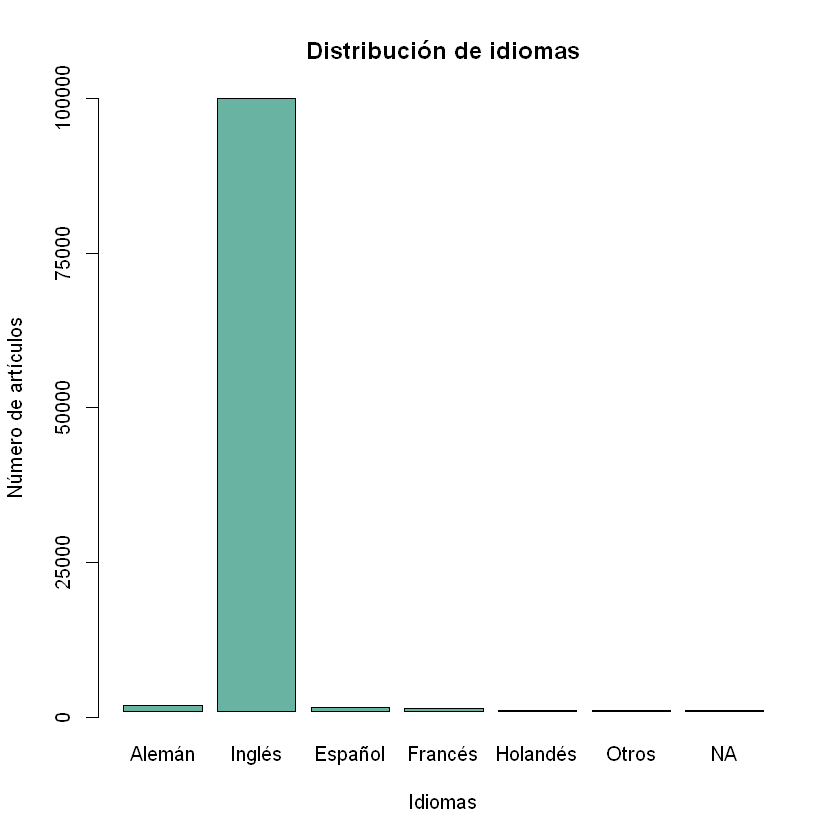

In [24]:
# Creación de matriz con los datos
idiomas <- matrix(c(842, 92212, 658, 517, 130, 71, 88), ncol = 7, byrow = TRUE)
colnames(idiomas) <- (c('Alemán','Inglés', 'Español', 'Francés', 'Holandés', 'Otros', 'NA'))
# Generación de gráfico 
barplot(idiomas, main = 'Distribución de idiomas', xlab = 'Idiomas', ylab = 'Número de artículos', col = '#69b3a2', axes = FALSE)
usr <- par("usr")
par(usr=c(usr[1:2], 0, 100000))
axis(2, at=seq(0, 100000,25000))

¡¡¡¡FILTRADO DE INGLES!!!! (covid_df_feather_ingles.csv)

In [27]:
# Nos quedamos únicamente con textos en inglés
covid_df <- covid_df[which(covid_df$language=='en'),]
# Mostramos el número de artículos restantes
nrow(covid_df)

[1] 92213

¡¡¡¡INFORMACION PALABRAS!!!!

In [28]:
# Información sobre el número de palabras
summary(covid_df[,c('words_abstract','words_body')])

 words_abstract.abstract_text words_body.body_text
 Min.   :   1.000             Min.   :     1.00   
 1st Qu.:   1.000             1st Qu.:  1658.00   
 Median : 162.000             Median :  3119.00   
 Mean   : 174.521             Mean   :  4022.11   
 3rd Qu.: 249.000             3rd Qu.:  4834.00   
 Max.   :7922.000             Max.   :293299.00   

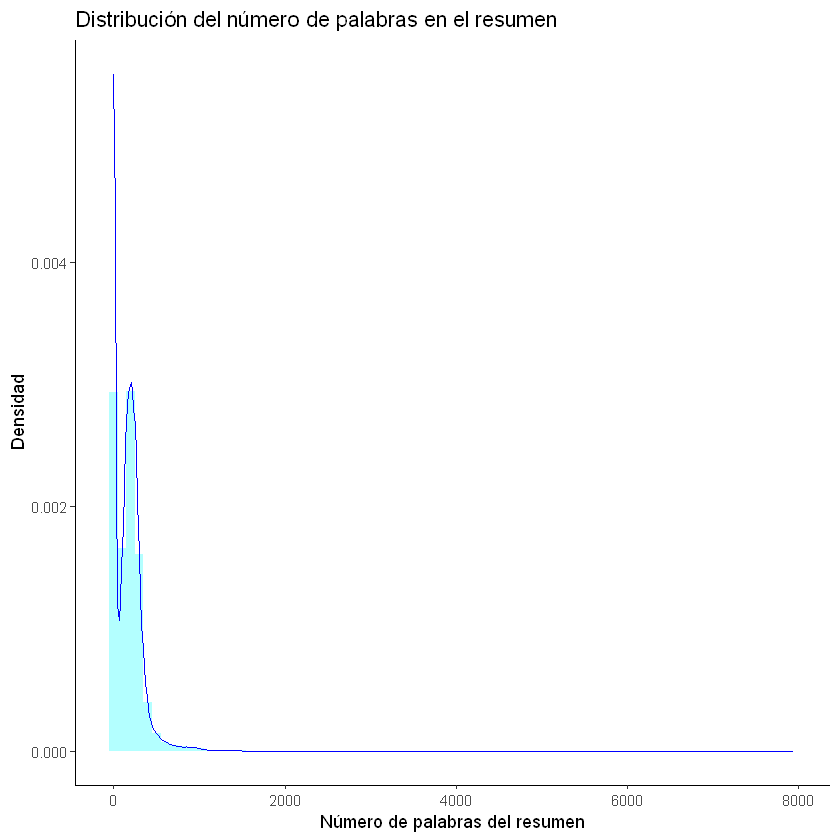

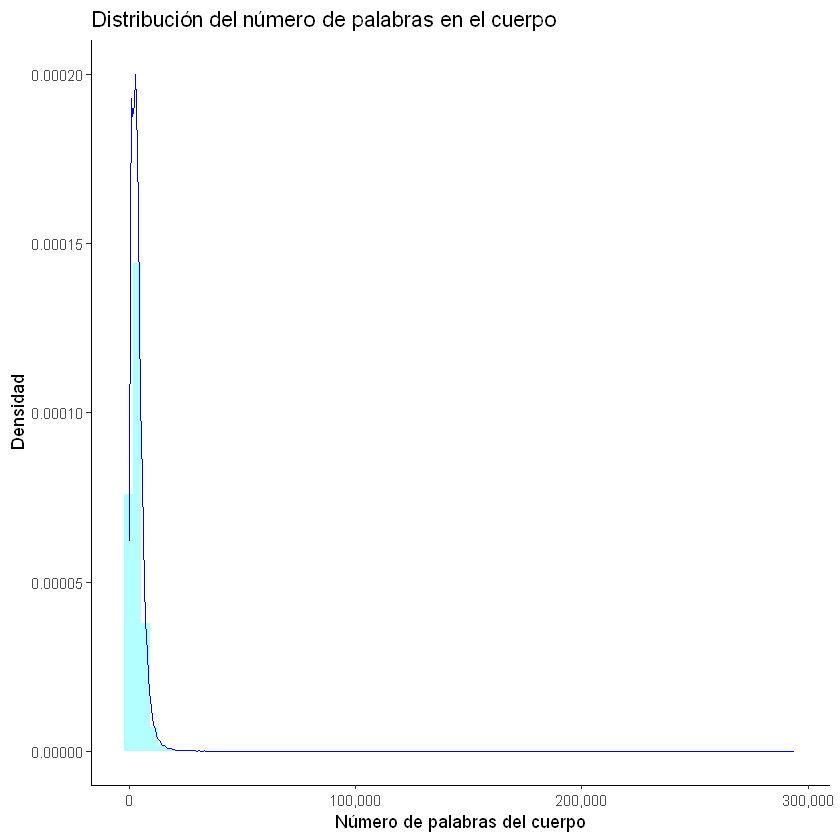

In [29]:
# Generación del grafo para el resumen con histograma y densidad
palabras_abstract <- ggplot(covid_df, aes(x=words_abstract)) + geom_histogram(aes(y=..density..), alpha=.3, fill="cyan", bins=80) + geom_density( colour="blue") + theme_classic() + ggtitle('Distribución del número de palabras en el resumen') +  xlab('Número de palabras del resumen') + ylab('Densidad')
# Misma operación para el cuerpo del texto
palabras_cuerpo <- ggplot(covid_df, aes(x=words_body)) + geom_histogram(aes(y=..density..), alpha=.3, fill="cyan", bins=80) + geom_density( colour="blue") + theme_classic() + scale_x_continuous(labels = comma) + ggtitle('Distribución del número de palabras en el cuerpo')  +  xlab('Número de palabras del cuerpo') + ylab('Densidad')
# Mostramos los gráficos
palabras_abstract
palabras_cuerpo

¡¡¡¡MAS INFORMACION PALABRAS!!!!

In [34]:
# Cinco primeros artículos con menos de diez palabras en el abstracto
covid_df[head(which(covid_df$words_abstract < 10 & covid_df$abstract_text != 'NoIncluido')), c('title_text', 'abstract_text', 'words_abstract')]

title_text,abstract_text,words_abstract
<chr>,<chr>,"<int[,1]>"
Loss of IKK subunits limits NF-<U+03BA>B signaling in reovirus infected cells 4 5,18,1
Title: Piloting Forensic Tele-Mental Health Evaluations of Asylum Seekers,Problem,1
NoIncluido,This article examines the changes made,6
A Cluster-Randomized Trial of Hydroxychloroquine as Prevention of Covid-19 Transmission and 1 Disease 2,Background 49,2
Early View Sleep apnoea management in Europe during the COVID-19 pandemic: data from the European Sleep Apnoea Database (ESADA),on behalf of the ESADA collaborators Affiliations:,7
"Initial characterisation of ELISA assays and the immune response of the clinically correlated SARS-CoV-2 biobank ""SERO-BL-COVID-19"" collected during the pandemic onset in Switzerland","Background To accurately measure seroprevalance in the population, both",9


In [36]:
# Y menos de diez palabras en el cuerpo
covid_df[head(which(covid_df$words_body < 10)), c('title_text', 'body_text', 'words_body')]

title_text,body_text,words_body
<chr>,<chr>,"<int[,1]>"
Severe SARS-CoV-2 infection in humans is defined by a shift in the serum lipidome resulting in dysregulation of eicosanoid immune mediators,Supplemental Figure 15,3
Journal Pre-proof How to optimize the management of gestational trophoblastic disease during the COVID era?,The authors report no conflict of interest.,7
NoIncluido,Journal Pre-proof Should,4
Journal Pre-proof Are healthcare workers during the COVID-19 pandemic at risk of psychosis? Findings from a scoping review Title: Are healthcare workers during the COVID-19 pandemic at risk of psychosis? Findings from a scoping review,results of a scoping review.,5
Der Chirurg Journal Club,Originalpublikation Sud,2
Journal Pre-proof THORACIC SURGERY FOR MALIGNANCY AND EMERGENCY IRRESPECTIVE OF COVID-19,To the Editor:,3


¡¡¡¡ELIMINACION DE PALABRAS!!!!

In [37]:
# Cargamos la lista del paquete stopwords
p_vacias <- stopwords::stopwords("en",source = "stopwords-iso")
# Añadimos más palabrasa 
p_propias <- c('doi', 'preprint', 'copyright', 'org', 'https', 'et', 'al', 'author', 'figure', 'table',
    'rights', 'reserved', 'permission', 'use', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI',
    '-PRON-', 'usually')
# Y las juntamos
p_vacias <- append(p_vacias, p_propias)
# Eliminamos cualquier posible duplicado
p_vacias <- unique(p_vacias)
# Vemos información al respecto
length(p_vacias)
sample(p_vacias, 10)

[1] 1317

[1] "trying"    "grouping"  "resulting" "ge"        "following" "sy"       
 [7] "primarily" "kw"        "one's"     "arent"

In [38]:
# Almacenamos el primer resumen para comparar
resumen <- covid_df$abstract_text[1]
# Conversión del resumen a minúsculas
covid_df$abstract_text <- apply(covid_df['abstract_text'], 2, function(s) tolower(s))
# Eliminación de signos de puntuación
covid_df$abstract_text <- apply(covid_df['abstract_text'], 2, function(s) removePunctuation(s, preserve_intra_word_contractions = TRUE, preserve_intra_word_dashes = TRUE))
# Eliminación de palabras vacías
covid_df$abstract_text <- apply(covid_df['abstract_text'], 2, function(s) remove_stopwords(s, p_vacias, lines = TRUE))
# Añadimos nueva columna con número de palabras actuales
covid_df$new_word_abstract <- apply(covid_df['abstract_text'], 2, function(s) str_count(s, '\\w+'))

In [ ]:
# Repetimos la operación con el cuerpo
# Conversión del cuerpo a minúsculas
covid_df$body_text <- apply(covid_df['body_text'], 2, function(s) tolower(s))
# Eliminación de signos de puntuación
covid_df$body_text <- apply(covid_df['body_text'], 2, function(s) removePunctuation(s))
# Eliminación de palabras vacías
covid_df$body_text <- apply(covid_df['body_text'], 2, function(s) remove_stopwords(s, p_vacias, lines = TRUE))
# Añadimos nueva columna con número de palabras actuales
covid_df$new_word_body <- apply(covid_df['body_text'], 2, function(s) str_count(s, '\\w+'))                            

In [41]:
# Comparamos el resumen original con el actual
substring(resumen, 1, 100)
substring(covid_df[1,'abstract_text'], 1, 100)

[1] " Feline infectious peritonitis virus (FIPV) positive cells are present in pyogranulomas and exudates"

[1] " feline infectious peritonitis virus fipv positive cells    pyogranulomas  exudates  cats  fip  cell"

¡¡¡¡COMPARAMOS NUMERO DE PALABRAS!!!!

In [45]:
# Creamos dos nuevas columnas con la resta de palabras originales y actuales
covid_df$abstract_comparative <- covid_df$words_abstract - covid_df$new_word_abstract
covid_df$body_comparative <- covid_df$words_body - covid_df$new_word_body
# Mostramos un resumen de la información
summary(covid_df[c('new_word_abstract', 'new_word_body', 'abstract_comparative', 'body_comparative')])
# Calculamos el total de palabras iniciales
inicial_resumen <- sum(covid_df$words_abstract)
inicial_cuerpo <- sum(covid_df$words_body)
inicial <- inicial_resumen + inicial_cuerpo
# Calculamos el total de palabras finales
final_resumen <- sum(covid_df$new_word_abstract)
final_cuerpo <- sum(covid_df$new_word_body)
final <- final_resumen + final_cuerpo
# Calculamos las palabras eliminadas
quitadas_resumen <- sum(covid_df$abstract_comparative)
quitadas_cuerpo <- sum(covid_df$body_comparative)
quitadas <- quitadas_resumen + quitadas_cuerpo
# Mostramos los datos
datos <- matrix(c(inicial_resumen, inicial_cuerpo, inicial, final_resumen, final_cuerpo, final, quitadas_resumen, quitadas_cuerpo, quitadas), nrow = 3, dimnames = list(c("Resumen", "Cuerpo", "Total"), c("Inicial", "Final", "Eliminadas")))
datos

 new_word_abstract new_word_body    abstract_comparative body_comparative
 Min.   :   0.00   Min.   :     1   Min.   :   0.00      Min.   :     0  
 1st Qu.:   1.00   1st Qu.:   848   1st Qu.:   0.00      1st Qu.:   798  
 Median :  88.00   Median :  1590   Median :  73.00      Median :  1504  
 Mean   :  95.74   Mean   :  2085   Mean   :  79.24      Mean   :  1945  
 3rd Qu.: 136.00   3rd Qu.:  2495   3rd Qu.: 111.00      3rd Qu.:  2343  
 Max.   :4696.00   Max.   :162073   Max.   :5126.00      Max.   :131565  

,Inicial,Final,Eliminadas
Resumen,16134914,8828313,7306601
Cuerpo,371628162,192247004,179381158
Total,387763076,201075317,186687759


¡¡¡¡GRAFICOS PARA LAS PALABRAS!!!!

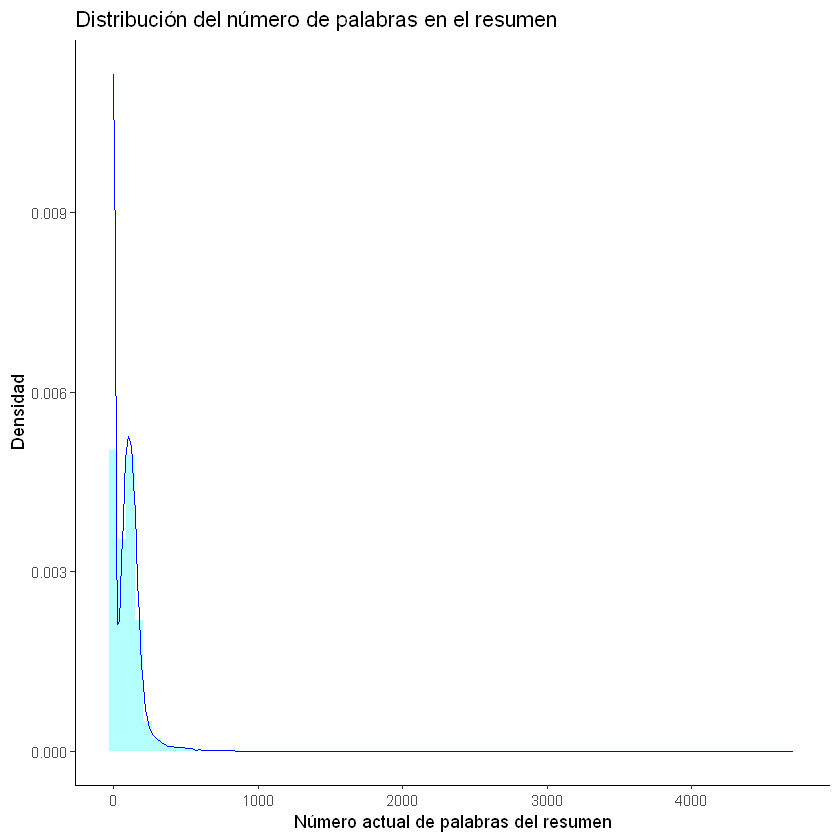

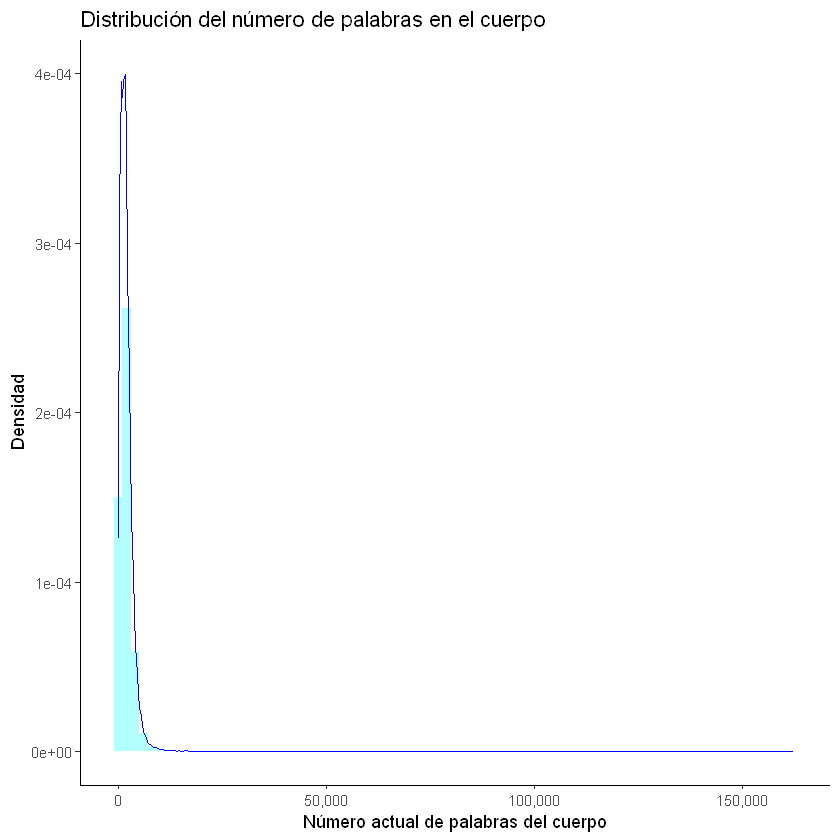

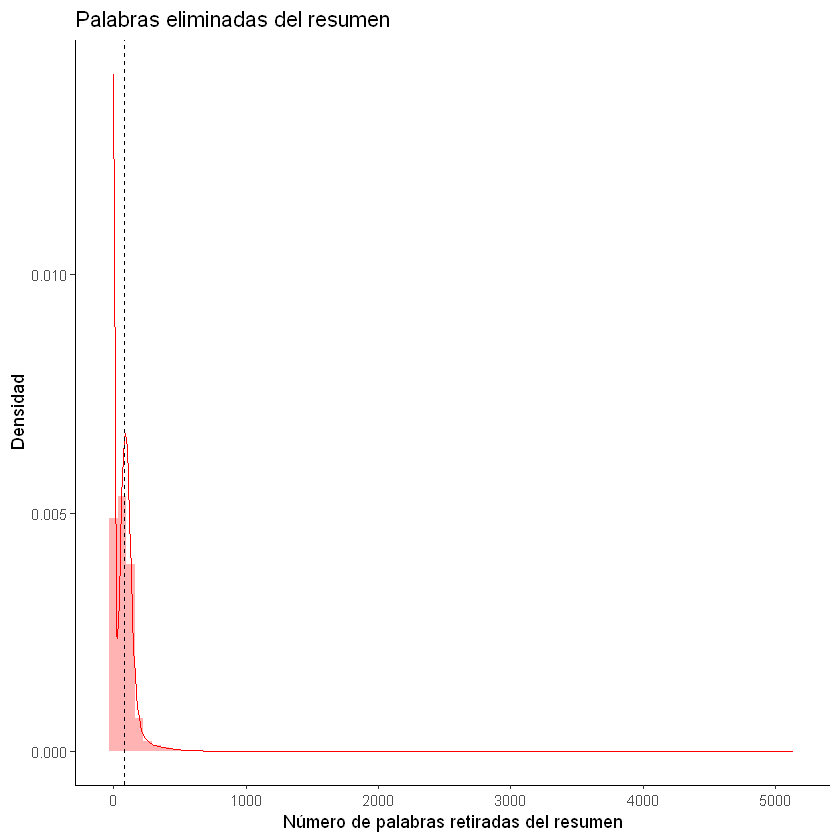

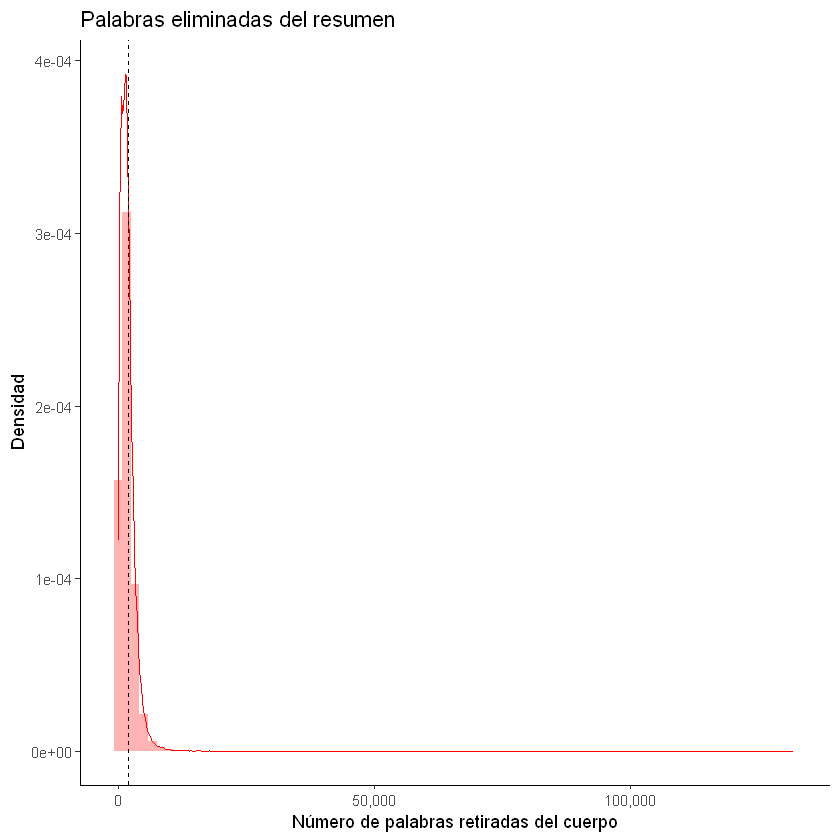

In [46]:
# Generación del grafo para el resumen con histograma y densidad
nuevas_palabras_abstract <- ggplot(covid_df, aes(x=new_word_abstract)) + geom_histogram(aes(y=..density..), alpha=.3, fill="cyan", bins=80) + geom_density( colour="blue") + theme_classic() + ggtitle('Distribución del número de palabras en el resumen') + xlab('Número actual de palabras del resumen') + ylab('Densidad')
# Misma operación para el cuerpo del texto
nuevas_palabras_cuerpo <- ggplot(covid_df, aes(x=new_word_body)) + geom_histogram(aes(y=..density..), alpha=.3, fill="cyan", bins=80) + geom_density( colour="blue") + theme_classic() + scale_x_continuous(labels = comma) + ggtitle('Distribución del número de palabras en el cuerpo') + xlab('Número actual de palabras del cuerpo') + ylab('Densidad')
# Generamos grafo para ver cuantas palabras se han quitado
comparacion_abstract<-ggplot(covid_df, aes(x=abstract_comparative)) + geom_histogram(aes(y=..density..), alpha=.3, fill="red", bins=80) + geom_density( colour="red") + theme_classic() + ggtitle('Palabras eliminadas del resumen') +  xlab('Número de palabras retiradas del resumen') + ylab('Densidad') + geom_vline(aes(xintercept= mean(abstract_comparative)), linetype="dashed")
# Misma operaciópn para el cuerpo del texto
comparacion_cuerpo <- ggplot(covid_df, aes(x=body_comparative)) + geom_histogram(aes(y=..density..), alpha=.3, fill="red", bins=80) + geom_density( colour="red") + theme_classic() + scale_x_continuous(labels = comma) + ggtitle('Palabras eliminadas del resumen') + xlab('Número de palabras retiradas del cuerpo') + ylab('Densidad') + geom_vline(aes(xintercept= mean(body_comparative)), linetype="dashed")

# Mostramos los gráficos
nuevas_palabras_abstract
nuevas_palabras_cuerpo
comparacion_abstract
comparacion_cuerpo

¡¡¡¡TOKENIZACION!!!!

In [54]:
# Tokenizamos tanto abstracto como texto completo
covid_df['abstract_text'] <- apply(covid_df['abstract_text'], 2, function(s) word_tokenizer(s, xptr = TRUE, pos_keep = character('-')))
covid_df['body_text'] <- apply(covid_df['body_text'], 2, function(s) word_tokenizer (s, xptr = TRUE))

# Mostramos los primeros cinco términos de los resúmenes y el cuerpo
covid_df$abstract_text[[1]][1:10]
covid_df$body_text[[1]][1:10]

[1] "feline"        "infectious"    "peritonitis"   "virus"        
 [5] "fipv"          "positive"      "cells"         "pyogranulomas"
 [9] "exudates"      "cats"

[1] "feline"      "infectious"  "peritonitis" "fip"         "fatal"      
 [6] "chronic"     "disease"     "cats"        "caused"      "coronavirus"

¡¡¡¡LEMATIZACION!!!!

In [50]:
# Haciendo "apply <- lapply" conseguimos una paralelización del trabajo gracias a la lista que genera la tokenización de los textos
system.time(covid_df['abstract_text'] <- apply(covid_df['abstract_text'], 2, function(s) lapply(s, function(t) lemmatize_words(t))))
system.time(covid_df['body_text'] <- apply(covid_df['body_text'], 2, function(s) lapply(s, function(t) lemmatize_words(t))))

!!MOSTRAR LEMATIZACION!!

In [52]:
# Mostramos los primeros cinco términos de los resúmenes y el cuerpo
covid_df$abstract_text[[1]][1:10]
covid_df$body_text[[1]][1:10]

[1] "feline"        "infectious"    "peritonitis"   "virus"        
 [5] "fipv"          "positive"      "cell"          "pyogranulomas"
 [9] "exudate"       "cat"

[1] "feline"      "infectious"  "peritonitis" "fip"         "fatal"      
 [6] "chronic"     "disease"     "cat"         "cause"       "coronavirus"

!!!Comparación palabras únicas!!

In [3]:
iniciales <- covid_df$words_body[1:5]
# Calculamos el total de palabras del cuerpo de los cinco primeros artículos...
finales <- c(length(covid_df$body_text[[1]]), length(covid_df$body_text[[2]]), length(covid_df$body_text[[3]]), length(covid_df$body_text[[4]]), length(covid_df$body_text[[5]]))
#... y las palabras únicas de los mismos
unicas <- c(length(unique(covid_df$body_text[[1]])), length(unique(covid_df$body_text[[2]])), length(unique(covid_df$body_text[[3]])), length(unique(covid_df$body_text[[4]])), length(unique(covid_df$body_text[[5]])))
# Creamos una matriz para comparar los valores y damos nombre a filas y columnas
comparacion <- matrix(c(iniciales, finales, unicas), nrow = 3, byrow = T)
dimnames(comparacion)<-list(c("Iniciales", "Finales","Unicas"), c("Artículo 1","Artículo 2","Artículo 3","Artículo 4","Artículo 5"))
comparacion

,Artículo 1,Artículo 2,Artículo 3,Artículo 4,Artículo 5
Iniciales,2120,2024,977,3331,2968
Finales,1089,1135,474,1838,1700
Unicas,417,496,260,486,631
